In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
!CUDA_LAUNCH_BLOCKING=1

In [3]:
# import os
# os._exit(00)

In [1]:
!pip install --upgrade google-cloud-storage

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.9 MB/s eta 0:00:00


In [3]:
import gc

### Machine possibilities research:

In [ ]:
!nvidia-smi

Thu Mar  6 14:45:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
batch_size = 1
while True:
    try:
        x = torch.randn(batch_size, 1, 16000).to("cuda")
        batch_size *= 2
    except RuntimeError:
        print(f"Max batch size before OOM: {batch_size // 2}")
        break

KeyboardInterrupt: 

In [ ]:
import multiprocessing
print(multiprocessing.cpu_count())

8


### Dataset loading

In [4]:
from google.colab import auth

In [5]:
auth.authenticate_user()

In [6]:
!gcloud auth login --quiet

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=dJvqFa4gCJtq7QjPFchfLKOFBgArVP&prompt=consent&token_usage=remote&access_type=offline&code_challenge=zmIbjUjuBJs_79nQQGG8ECV-dnQDkht_ZHZUT9rnDVc&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AQSTgQHANilwtohBG7aFExmHSfLwGgpHIz3PE3u4n1MxD30zk9pW8otvO_M_Q9hxOGPRcg

You are now logged in as [khrystyna.dol.3@gmail.com].
Your current proj

In [7]:
!gcloud config set project ser-diploma

Updated property [core/project].


### Dataset processing:

In [ ]:
from google.cloud import storage

client = storage.Client()
bucket_name = "mc-eiu-data"

bucket = client.bucket(bucket_name)
blobs = bucket.list_blobs()

for blob in blobs:
    print(blob.name)
    break

del bucket, blobs
gc.collect()

EnglishDialogues.csv


0

In [ ]:
import os
import pandas as pd
from google.cloud import storage

BUCKET_NAME = "mc-eiu-data"
CSV_FILE_PATH = f"EnglishDialogues.csv"
AUDIO_FOLDER_PATH = "MC-EIU-audio/"
LOCAL_AUDIO_DIR = "/content/mc-eiu-data/"

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

blob = bucket.blob(CSV_FILE_PATH)
csv_content = blob.download_as_text()
df = pd.read_csv(pd.io.common.StringIO(csv_content))

def get_audio_filename(dia, utt):
    return f"dia_{dia}_utt_{utt}.mp3"

def file_exists_in_bucket(filename):
    return storage.Blob(bucket=bucket, name=f"{AUDIO_FOLDER_PATH}{filename}").exists(storage_client)

dataset = []
idx = 0
for _, row in df.iterrows():
    audio_filename = get_audio_filename(row["Dia_No"], row["Utt_No"])

    if file_exists_in_bucket(audio_filename):
        dataset.append({
            "audio_file": f"gs://{BUCKET_NAME}/{AUDIO_FOLDER_PATH}{audio_filename}",
            "audio_file_local": f"{LOCAL_AUDIO_DIR}{audio_filename}",
            "text": row["Script"],
            "emotion": row["emotion"],
            "intent": row["intent"],
            "speaker": row["speaker"],
            "dialogue_id": row["Dia_No"],
            "utterance_id": row["Utt_No"]
        })
    if idx % 1000 == 0:
      print("Files processed", idx)
    idx += 1

dataset_df = pd.DataFrame(dataset)

print(f"Loaded dataset with {len(dataset_df)} matched samples.")
dataset_df.head()

Files processed 0
Files processed 1000
Files processed 2000
Files processed 3000
Files processed 4000
Files processed 5000
Files processed 6000
Files processed 7000
Files processed 8000
Files processed 9000
Files processed 10000
Files processed 11000
Files processed 12000
Files processed 13000
Files processed 14000
Files processed 15000
Files processed 16000
Files processed 17000
Files processed 18000
Files processed 19000
Files processed 20000
Files processed 21000
Files processed 22000
Files processed 23000
Files processed 24000
Files processed 25000
Files processed 26000
Files processed 27000
Files processed 28000
Files processed 29000
Files processed 30000
Files processed 31000
Files processed 32000
Files processed 33000
Files processed 34000
Files processed 35000
Files processed 36000
Files processed 37000
Files processed 38000
Files processed 39000
Files processed 40000
Files processed 41000
Files processed 42000
Files processed 43000
Files processed 44000
Files processed 45000
L

,audio_file,audio_file_local,text,emotion,intent,speaker,dialogue_id,utterance_id
0,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_0.mp3,/content/mc-eiu-data/dia_1_utt_0.mp3,"Ross: Hi... There she is. Hi Emma. Oh my God,...",happy,questioning,0,1,0
1,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_1.mp3,/content/mc-eiu-data/dia_1_utt_1.mp3,"Rachel: That was one time, Ross, and they were...",neutral,neutral,1,1,1
2,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_2.mp3,/content/mc-eiu-data/dia_1_utt_2.mp3,"Ross: Ooh hey, Emma, daddy has some presents f...",neutral,wishing,0,1,2
3,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_3.mp3,/content/mc-eiu-data/dia_1_utt_3.mp3,"Rachel: Aaah... Ross, actually there's somethi...",anger,neutral,1,1,3
4,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_4.mp3,/content/mc-eiu-data/dia_1_utt_4.mp3,"Ross: Okay, shoot! \n",neutral,agreeing,0,1,4


In [ ]:
dataset_df["emotion"].value_counts()

,count
emotion,
neutral,21428
happy,12622
anger,4476
sad,2649
surprise,1732
fear,1256
disgust,844


In [ ]:
dataset_df["intent"].value_counts()

,count
intent,
neutral,17767
questioning,10131
suggesting,4748
consoling,4009
agreeing,2997
wishing,2714
encouraging,1792
acknowledging,584
sympathizing,265


In [ ]:
emotion_to_label = {
    "neutral": 0, "happy": 1, "anger": 2, "sad": 3,
    "surprise": 4, "fear": 5, "disgust": 6
}

dataset_df["emotion_label"] = dataset_df["emotion"].map(emotion_to_label).fillna(-1).astype(int)
dataset_df.head()

,audio_file,audio_file_local,text,emotion,intent,speaker,dialogue_id,utterance_id,emotion_label
0,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_0.mp3,/content/mc-eiu-data/dia_1_utt_0.mp3,"Ross: Hi... There she is. Hi Emma. Oh my God,...",happy,questioning,0,1,0,1
1,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_1.mp3,/content/mc-eiu-data/dia_1_utt_1.mp3,"Rachel: That was one time, Ross, and they were...",neutral,neutral,1,1,1,0
2,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_2.mp3,/content/mc-eiu-data/dia_1_utt_2.mp3,"Ross: Ooh hey, Emma, daddy has some presents f...",neutral,wishing,0,1,2,0
3,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_3.mp3,/content/mc-eiu-data/dia_1_utt_3.mp3,"Rachel: Aaah... Ross, actually there's somethi...",anger,neutral,1,1,3,2
4,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_4.mp3,/content/mc-eiu-data/dia_1_utt_4.mp3,"Ross: Okay, shoot! \n",neutral,agreeing,0,1,4,0


In [ ]:
dataset_df["emotion_label"].value_counts()

,count
emotion_label,
0,21428
1,12622
2,4476
3,2649
4,1732
5,1256
6,844


In [ ]:
local_csv_path = "/content/processed_dataset_local.csv"
dataset_df.to_csv(local_csv_path, index=False)
print(f"Saved locally at: {local_csv_path}")

OUTPUT_CSV_PATH = "MC-EIU-processed_local.csv"

output_blob = bucket.blob(OUTPUT_CSV_PATH)
output_blob.upload_from_filename(local_csv_path)
print(f"Uploaded to GCS: gs://{BUCKET_NAME}/{OUTPUT_CSV_PATH}")

Saved locally at: /content/processed_dataset_local.csv
Uploaded to GCS: gs://mc-eiu-data/MC-EIU-processed_local.csv


### Loading dataset from gcp bucket:

In [8]:
import pandas as pd
import gcsfs

fs = gcsfs.GCSFileSystem(project='ser-diploma')
gcs_path = 'gs://mc-eiu-data/MC-EIU-processed_local.csv'

with fs.open(gcs_path, 'r') as f:
    df = pd.read_csv(f)

df.head()

,audio_file,audio_file_local,text,emotion,intent,speaker,dialogue_id,utterance_id,emotion_label
0,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_0.mp3,/content/mc-eiu-data/dia_1_utt_0.mp3,"Ross: Hi... There she is. Hi Emma. Oh my God,...",happy,questioning,0,1,0,1
1,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_1.mp3,/content/mc-eiu-data/dia_1_utt_1.mp3,"Rachel: That was one time, Ross, and they were...",neutral,neutral,1,1,1,0
2,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_2.mp3,/content/mc-eiu-data/dia_1_utt_2.mp3,"Ross: Ooh hey, Emma, daddy has some presents f...",neutral,wishing,0,1,2,0
3,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_3.mp3,/content/mc-eiu-data/dia_1_utt_3.mp3,"Rachel: Aaah... Ross, actually there's somethi...",anger,neutral,1,1,3,2
4,gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_4.mp3,/content/mc-eiu-data/dia_1_utt_4.mp3,"Ross: Okay, shoot! \n",neutral,agreeing,0,1,4,0


In [ ]:
df = df[['audio_file_local', 'emotion_label']].copy()
df.head()

,audio_file_local,emotion_label
0,/content/mc-eiu-data/dia_1_utt_0.mp3,1
1,/content/mc-eiu-data/dia_1_utt_1.mp3,0
2,/content/mc-eiu-data/dia_1_utt_2.mp3,0
3,/content/mc-eiu-data/dia_1_utt_3.mp3,2
4,/content/mc-eiu-data/dia_1_utt_4.mp3,0


### Loading data:

In [12]:
# train_ratio = 0.8
# dataset_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
# split_idx = int(len(dataset_shuffled) * train_ratio)

# train_dataset = dataset_shuffled[:split_idx]
# test_dataset = dataset_shuffled[split_idx:]

# print(f"Train set: {len(train_dataset)} samples, Test set: {len(test_dataset)} samples")

# train_ratio = 0.7
# val_ratio = 0.15

# dataset_reduced = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
# dataset_shuffled = dataset_reduced.sample(frac=1, random_state=42).reset_index(drop=True)

# train_idx = int(len(dataset_shuffled) * train_ratio)
# val_idx = int(len(dataset_shuffled) * (train_ratio + val_ratio))

# train_dataset = dataset_shuffled[:train_idx]
# val_dataset = dataset_shuffled[train_idx:val_idx]
# test_dataset = dataset_shuffled[val_idx:]

# print(f"Train set: {len(train_dataset)} samples")
# print(f"Validation set: {len(val_dataset)} samples")
# print(f"Test set: {len(test_dataset)} samples")

import pandas as pd

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

min_samples_per_class = int(len(df) * 0.08 / 6)

dataset_reduced = (
    df.groupby("emotion_label", group_keys=False)
    .apply(lambda x: x.sample(n=min_samples_per_class, random_state=42))
    .reset_index(drop=True)
)

dataset_shuffled = dataset_reduced.sample(frac=1, random_state=42).reset_index(drop=True)

train_idx = int(len(dataset_shuffled) * train_ratio)
val_idx = int(len(dataset_shuffled) * (train_ratio + val_ratio))

train_dataset = dataset_shuffled[:train_idx]
val_dataset = dataset_shuffled[train_idx:val_idx]
test_dataset = dataset_shuffled[val_idx:]

print(f"Train set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

print("Train label distribution:\n", train_dataset["emotion_label"].value_counts(normalize=True))
print("Validation label distribution:\n", val_dataset["emotion_label"].value_counts(normalize=True))
print("Test label distribution:\n", test_dataset["emotion_label"].value_counts(normalize=True))

Train set: 2940 samples
Validation set: 630 samples
Test set: 630 samples
Train label distribution:
 emotion_label
6    0.148980
0    0.145578
2    0.144558
1    0.141837
3    0.141497
4    0.140476
5    0.137075
Name: proportion, dtype: float64
Validation label distribution:
 emotion_label
3    0.174603
5    0.160317
0    0.149206
4    0.146032
2    0.133333
1    0.125397
6    0.111111
Name: proportion, dtype: float64
Test label distribution:
 emotion_label
1    0.165079
5    0.152381
4    0.150794
6    0.146032
2    0.144444
0    0.123810
3    0.117460
Name: proportion, dtype: float64


<ipython-input-12-0fc09a8533e5>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_samples_per_class, random_state=42))


In [18]:
del df
gc.collect()

1966

In [19]:
train_dataset["emotion_label"].value_counts(normalize=True) * 100

,proportion
emotion_label,
6,14.897959
0,14.557823
2,14.455782
1,14.183673
3,14.149660
4,14.047619
5,13.707483


In [20]:
test_dataset["emotion_label"].value_counts(normalize=True) * 100

,proportion
emotion_label,
1,16.507937
5,15.238095
4,15.079365
6,14.603175
2,14.444444
0,12.380952
3,11.746032


In [21]:
emotion_to_label = {
    "neutral": 0, "happy": 1, "anger": 2, "sad": 3,
    "surprise": 4, "fear": 5, "disgust": 6
}

label_convert = {
    'LABEL_0': "neutral",
    'LABEL_1': "happy",
    'LABEL_2': "anger",
    'LABEL_3': "sad",
    'LABEL_4': "surprise",
    'LABEL_5': "fear",
    'LABEL_6': "disgust"
}

### Processing data on disk:

In [13]:
import os
import concurrent.futures
from google.cloud import storage

GCS_BUCKET_NAME = "mc-eiu-data"
LOCAL_AUDIO_DIR = "/content/mc-eiu-data"

os.makedirs(LOCAL_AUDIO_DIR, exist_ok=True)

storage_client = storage.Client()
bucket = storage_client.bucket(GCS_BUCKET_NAME)

def download_audio_from_gcs(gcs_path):
    """Downloads a single file from GCS to local disk (only if not already downloaded)."""
    filename = os.path.basename(gcs_path)
    local_path = os.path.join(LOCAL_AUDIO_DIR, filename)

    if os.path.exists(local_path):
        return local_path

    blob = bucket.blob(gcs_path.replace(f"gs://{GCS_BUCKET_NAME}/", ""))
    blob.download_to_filename(local_path)
    return local_path

def download_files_parallel(dataset):
    """Downloads all audio files in parallel for a given dataset."""
    gcs_paths = dataset["audio_file"].tolist()

    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        local_paths = list(executor.map(download_audio_from_gcs, gcs_paths))

    # dataset["audio_file_local_path"] = local_paths
    # dataset.loc[:, "audio_file_local_path"] = local_paths

In [14]:
for dataset in [train_dataset, val_dataset, test_dataset]:
    download_files_parallel(dataset)

print("All files downloaded to:", LOCAL_AUDIO_DIR)

All files downloaded to: /content/mc-eiu-data


In [15]:
!ls -l /content/mc-eiu-data | wc -l

4201


In [16]:
train_dataset.head()

,audio_file,audio_file_local,text,emotion,intent,speaker,dialogue_id,utterance_id,emotion_label
0,gs://mc-eiu-data/MC-EIU-audio/dia_4103_utt_4.mp3,/content/mc-eiu-data/dia_4103_utt_4.mp3,-,anger,questioning,0,4103,4,2
1,gs://mc-eiu-data/MC-EIU-audio/dia_2994_utt_2.mp3,/content/mc-eiu-data/dia_2994_utt_2.mp3,-,sad,neutral,0,2994,2,3
2,gs://mc-eiu-data/MC-EIU-audio/dia_3513_utt_2.mp3,/content/mc-eiu-data/dia_3513_utt_2.mp3,-,anger,suggesting,0,3513,2,2
3,gs://mc-eiu-data/MC-EIU-audio/dia_1714_utt_11.mp3,/content/mc-eiu-data/dia_1714_utt_11.mp3,"Sheldon: Well, I thought, if I have a stroke o...",fear,wishing,1,1714,11,5
4,gs://mc-eiu-data/MC-EIU-audio/dia_1494_utt_9.mp3,/content/mc-eiu-data/dia_1494_utt_9.mp3,"Amy: Sheldon, please, you’re suffocating me.\n",neutral,neutral,1,1494,9,0


In [17]:
train_dataset = train_dataset[['audio_file_local', 'emotion_label']].copy()
# train_dataset.head()

val_dataset = val_dataset[['audio_file_local', 'emotion_label']].copy()
test_dataset = test_dataset[['audio_file_local', 'emotion_label']].copy()

In [ ]:
import os

local_audio_dir = "/content/mc-eiu-data"
dataset_files = set(os.listdir(local_audio_dir))

for dataset in [train_dataset, val_dataset, test_dataset]:
    missing_files = [path for path in dataset["audio_file_local_path"] if os.path.basename(path) not in dataset_files]

    if missing_files:
        print(f"Missing or corrupted files: {len(missing_files)}")
        print(missing_files[:5])

In [ ]:
import librosa

def safe_load_audio(file_path, sr=8000):
    if not os.path.exists(file_path):
        print(f"Warning: Missing file {file_path}, skipping.")
        return None, None

    try:
        speech, _ = librosa.load(file_path, sr=sr, mono=True)
        return speech, _
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

speech, _ = safe_load_audio("/content/mc-eiu-data/dia_1901_utt_1.mp3")

Error loading /content/mc-eiu-data/dia_1901_utt_1.mp3: 


<ipython-input-29-25dc94342aae>:9: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, _ = librosa.load(file_path, sr=sr, mono=True)


### Model setup and training 1:

In [22]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["audio_file_local"], sr=16000, mono=True)
    example["speech"] = speech
    return example

In [23]:
train_data = Dataset.from_pandas(train_dataset).map(map_to_array)
val_data = Dataset.from_pandas(val_dataset).map(map_to_array)
test_data = Dataset.from_pandas(test_dataset).map(map_to_array)

Map:   0%|          | 0/2940 [00:00<?, ? examples/s]

Map:   0%|          | 0/630 [00:00<?, ? examples/s]

Map:   0%|          | 0/630 [00:00<?, ? examples/s]

In [24]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")  # , num_labels=num_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [25]:
train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
val_encodings = feature_extractor(list(val_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

In [26]:
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        # self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
        # self.pattern = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7}
        self.pattern = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
        # pattern = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}
        # self.labels = [pattern[x] for x in labels]
        self.labels = [self.pattern.get(x) for x in labels]
        # self.labels = [self.pattern.get(x, -1) for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        label = self.labels[idx]
        if label == -1:
            raise ValueError(f"Invalid label at index {idx}: Original label {self.labels[idx]}, this: {label}")
        item['emotion_label'] = torch.tensor(label)
        return item

    # def __getitem__(self, idx):
    #     item = {key: val[idx] for key, val in self.encodings.items()}
    #     item['emotion_label'] = torch.tensor(self.labels[idx])
    #     return item

    def __len__(self):
        return len(self.labels)


train_dataset = CustomDataset(train_encodings, list(train_data["emotion_label"]))
val_dataset = CustomDataset(val_encodings, list(val_data["emotion_label"]))
test_dataset = CustomDataset(test_encodings, list(test_data["emotion_label"]))

In [27]:
print(train_dataset)

In [28]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

num_labels=7
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er", num_labels=num_labels, ignore_mismatched_sizes=True)
# model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft", num_labels=8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.gradient_checkpointing_enable()
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [30]:
print(train_dataset.labels)

[2, 3, 2, 5, 0, 3, 6, 0, 5, 4, 1, 3, 2, 6, 4, 3, 5, 0, 3, 1, 5, 1, 1, 4, 4, 6, 3, 1, 0, 3, 0, 4, 4, 0, 1, 3, 1, 1, 3, 1, 6, 4, 1, 0, 2, 0, 3, 4, 1, 1, 2, 4, 1, 6, 2, 0, 0, 2, 1, 6, 6, 2, 4, 0, 1, 3, 3, 1, 3, 5, 6, 6, 4, 0, 1, 6, 0, 4, 2, 2, 3, 0, 4, 0, 0, 5, 3, 1, 4, 3, 0, 0, 6, 1, 3, 6, 6, 2, 5, 6, 0, 1, 6, 0, 4, 2, 3, 3, 2, 0, 1, 6, 4, 0, 0, 3, 5, 3, 6, 6, 6, 2, 6, 3, 0, 4, 5, 0, 1, 3, 2, 0, 0, 0, 4, 0, 3, 5, 0, 4, 0, 0, 0, 3, 4, 1, 5, 4, 0, 0, 2, 0, 2, 6, 4, 6, 1, 3, 3, 3, 1, 4, 1, 5, 2, 1, 5, 2, 1, 0, 6, 6, 1, 1, 0, 3, 5, 6, 2, 6, 0, 6, 3, 1, 4, 2, 2, 6, 3, 1, 6, 5, 2, 6, 0, 6, 1, 4, 2, 1, 6, 5, 3, 5, 4, 1, 5, 1, 5, 6, 4, 5, 2, 3, 3, 6, 5, 1, 0, 4, 1, 3, 4, 4, 0, 1, 6, 3, 2, 4, 1, 4, 1, 3, 6, 6, 3, 2, 3, 2, 6, 4, 2, 6, 4, 5, 0, 0, 0, 1, 6, 3, 2, 0, 5, 0, 6, 3, 5, 2, 3, 2, 1, 4, 4, 6, 1, 6, 0, 4, 3, 5, 5, 1, 1, 1, 1, 4, 2, 4, 1, 1, 3, 3, 2, 6, 2, 5, 0, 2, 6, 4, 0, 2, 4, 2, 4, 0, 2, 1, 5, 0, 3, 5, 2, 5, 4, 6, 3, 4, 3, 6, 2, 2, 2, 1, 2, 3, 3, 3, 4, 0, 2, 4, 0, 5, 4, 6, 5, 3, 0, 5, 0, 

In [31]:
len(train_dataset)

2940

In [ ]:
print("Clearing GPU cache...")
torch.cuda.empty_cache()

Clearing GPU cache...


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [32]:
print(set(train_data["emotion_label"]))

{0, 1, 2, 3, 4, 5, 6}


In [34]:
# import torch
# import time
# from tqdm import tqdm
# from torch.utils.data import DataLoader

# epoch = 4
# model.train()

# train_loss = []
# train_accuracies = []

# for epoch_i in range(epoch):
#     print(f'Epoch {epoch_i + 1}/{epoch}')
#     time.sleep(0.3)

#     train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, pin_memory=False)

#     correct = 0
#     count = 0
#     epoch_loss = []

#     pbar = tqdm(train_loader)

#     for i, batch in enumerate(pbar):
#         optim.zero_grad()

#         input_ids = batch['input_values'].to(device, non_blocking=True)
#         attention_mask = batch['attention_mask'].to(device, non_blocking=True)
#         labels = batch['emotion_label'].to(device, non_blocking=True)

#         if i % 50 == 0:
#             print(f"GPU Memory Usage Before Forward: {torch.cuda.memory_allocated() / 1e9:.3f} GB")

#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs['loss']

#         loss.backward()
#         optim.step()

#         if i % 50 == 0:
#             print(f"GPU Memory Usage After Backward: {torch.cuda.memory_allocated() / 1e9:.3f} GB")

#         with torch.no_grad():
#             predictions = predict(outputs)

#         correct += predictions.eq(labels).sum().item()
#         count += len(labels)
#         accuracy = correct / count

#         pbar.set_postfix({
#             'Loss': f'{loss.item():.3f}',
#             'Accuracy': f'{accuracy:.3f}'
#         })

#         epoch_loss.append(loss.item())

#         # del input_ids, attention_mask, labels, outputs, loss
#         # torch.cuda.empty_cache()

#     if epoch_i == 0 or accuracy > max(train_accuracies):
#         torch.save(model.state_dict(), f"mc-eiu-hubert-model.pth")

#     pbar.close()

#     train_loss.extend(epoch_loss)
#     train_accuracies.append(accuracy)

#     torch.cuda.empty_cache()
#     time.sleep(1)

import torch
import time
from tqdm import tqdm
from google.colab import files
from torch.utils.data import DataLoader

epoch = 4
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    correct = 0
    count = 0
    epoch_loss = list()

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['emotion_label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()

        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })

        epoch_loss.append(loss.item())

    torch.save(model.state_dict(), f"mc-eiu-hubert-model-10-normalized-{epoch_i}.pth")
    files.download(f"mc-eiu-hubert-model-10-normalized-{epoch_i}.pth")

    pbar.close()

    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/4


100%|██████████| 1470/1470 [1:27:33<00:00,  3.57s/it, Loss=1.830, Accuracy=0.184]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 2/4


100%|██████████| 1470/1470 [1:27:18<00:00,  3.56s/it, Loss=1.791, Accuracy=0.189]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 3/4


100%|██████████| 1470/1470 [1:27:23<00:00,  3.57s/it, Loss=1.506, Accuracy=0.213]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 4/4


100%|██████████| 1470/1470 [1:27:12<00:00,  3.56s/it, Loss=1.846, Accuracy=0.255]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

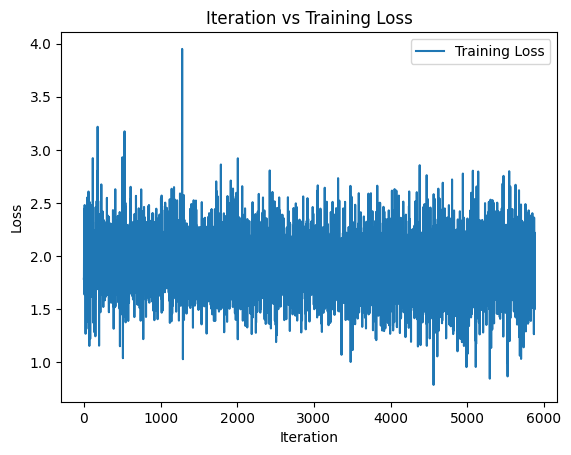

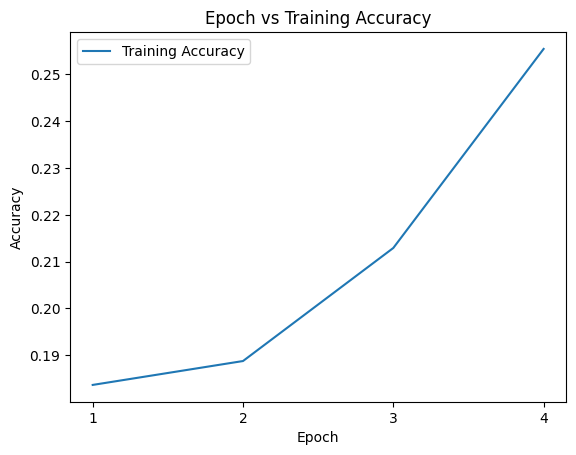

[1 2 3 4]
[0.1836734693877551, 0.18877551020408162, 0.21292517006802722, 0.25544217687074827]


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X_1 = np.arange(len(train_accuracies))+1
plt.plot(acc_X_1, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X_1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")
plt.legend()
plt.show()

print(acc_X_1)
train_accuracies1=train_accuracies
print(train_accuracies1)

In [36]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
model.eval()

with torch.no_grad():
    correct = 0
    count = 0
    record = {"emotion_label":list(), "predictions":list()}

    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['emotion_label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        predictions = predict(outputs)
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })

        record["emotion_label"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()

    pbar.close()

time.sleep(0.3)
print("The accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 630/630 [04:13<00:00,  2.49it/s, loss=1.824, accuracy=0.214]


The accuracy on the test dataset: 21.4286%


In [37]:
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Real emotion", "Predicted emotion"]

def get_emotion(label_id):
    return model.config.id2label[label_id]

df_record["Real emotion"] = df_record.apply(lambda x: get_emotion(x["Real emotion"]), axis=1)
df_record["Predicted emotion"] = df_record.apply(lambda x: get_emotion(x["Predicted emotion"]), axis=1)

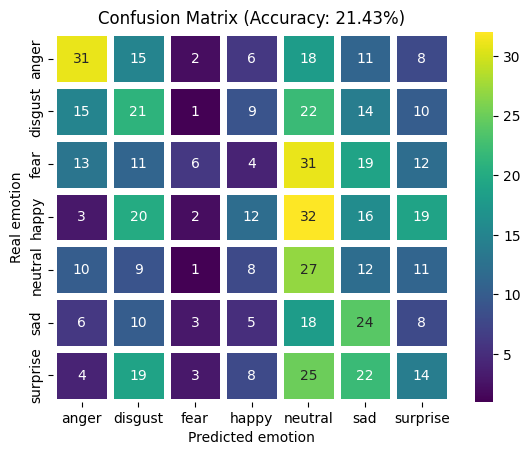

In [38]:
import seaborn as sns
crosstab = pd.crosstab(df_record["Real emotion"].map(label_convert), df_record["Predicted emotion"].map(label_convert))
sns.heatmap(crosstab, cmap='viridis', annot=True, fmt='g', linewidths=5)
# sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Real emotion"].eq(df_record["Predicted emotion"]).sum() / len(df_record["Real emotion"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [ ]:
import time
from tqdm import tqdm
from torch.utils.data import DataLoader

epoch = 4
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=False)

    correct = 0
    count = 0
    epoch_loss = list()

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['emotion_label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()

        with torch.no_grad():
            predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })

        epoch_loss.append(loss.item())

        del input_ids, attention_mask, labels, outputs, loss
        torch.cuda.empty_cache()

    if epoch_i == 0 or accuracy > max(train_accuracies):
        torch.save(model.state_dict(), f"mc-eiu-hubert-model.pth")
    pbar.close()

    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/4


  0%|          | 0/1575 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Model setup and training:

In [ ]:
import torch
import librosa
from datasets import Dataset
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
from transformers import Wav2Vec2FeatureExtractor

In [ ]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")  # , sampling_rate=8000)  # , num_labels=num_labels)
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [ ]:
def map_to_array(example):
    speech, _ = librosa.load(example["audio_file_local"], sr=1600, mono=True)
    example["speech"] = speech
    # del speech
    # gc.collect()
    return example

In [ ]:
def process_batch(batch):
    batch["input_values"] = feature_extractor(
        batch["speech"], sampling_rate=8000, padding=True, return_tensors="pt"
    )["input_values"]
    return batch

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, dataset, feature_extractor, max_length=16000):
#         self.dataset = dataset
#         self.feature_extractor = feature_extractor
#         self.max_length = max_length
#         self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         audio_path = self.dataset.iloc[idx]["audio_file_local"]
#         speech, _ = librosa.load(audio_path, sr=8000, mono=True)

#         encodings = self.feature_extractor(
#             speech,
#             sampling_rate=8000,
#             padding="max_length",
#             max_length=self.max_length,
#             truncation=True,
#             return_tensors="pt",
#         )
#         label = torch.tensor(self.pattern.get(self.dataset.iloc[idx]["emotion_label"], -1))
#         return {"input_values": encodings["input_values"].squeeze(0), "emotion_label": label}


# class CustomDataset(Dataset):
#     def __init__(self, dataset, feature_extractor):
#         self.dataset = dataset
#         self.feature_extractor = feature_extractor
#         self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         audio_path = self.dataset.iloc[idx]["audio_file_local"]
#         speech, _ = librosa.load(audio_path, sr=8000, mono=True)

#         encodings = self.feature_extractor(
#             speech, sampling_rate=8000, padding=True, return_tensors="pt"
#         )

#         label = torch.tensor(self.pattern.get(self.dataset.iloc[idx]["emotion_label"], -1))
#         return {"input_values": encodings["input_values"].squeeze(0), "emotion_label": label}

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
        self.labels = [self.pattern.get(x) for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['emotion_label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
#         self.labels = [self.pattern.get(x, -1) for x in labels]

#     def __getitem__(self, idx):
#         item = {key: val[idx] for key, val in self.encodings.items()}
#         label = self.labels[idx]
#         if label == -1:
#             print(f"Warning: Invalid label at index {idx}")
#         item['emotion_label'] = torch.tensor(label)
#         return item

#     def __len__(self):
#         return len(self.labels)

In [ ]:
train_dataset["speech"] = train_dataset["audio_file_local"].apply(
    lambda x: librosa.load(x, sr=8000, mono=True)[0]
)

<ipython-input-16-931b65e119cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset["speech"] = train_dataset["audio_file_local"].apply(


In [ ]:
# train_dataset = CustomDataset(train_dataset, feature_extractor)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# for batch in train_loader:
#     print(batch["input_values"].shape, batch["emotion_label"].shape)
#     break

# train_data = Dataset.from_pandas(train_dataset)
# train_data = train_data.map(process_batch, batched=True, batch_size=16)
# train_dataset = CustomDataset(train_data["input_values"], list(train_data["emotion_label"]))

# del train_data
# gc.collect()


train_data = Dataset.from_pandas(train_dataset).map(map_to_array)
train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

train_dataset = CustomDataset(train_encodings, list(train_data["emotion_label"]))
del train_encodings, train_data
gc.collect()

Map:   0%|          | 0/3150 [00:00<?, ? examples/s]

3

In [ ]:
val_data = Dataset.from_pandas(val_dataset).map(map_to_array)
val_encodings = feature_extractor(list(val_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

val_dataset = CustomDataset(val_encodings, list(val_data["emotion_label"]))
del val_encodings, val_data
gc.collect()

Map:   0%|          | 0/675 [00:00<?, ? examples/s]

3

In [ ]:
test_data = Dataset.from_pandas(test_dataset).map(map_to_array)
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

test_dataset = CustomDataset(test_encodings, list(test_data["emotion_label"]))
del test_encodings, test_data
gc.collect()

Map:   0%|          | 0/676 [00:00<?, ? examples/s]

20

In [ ]:
from torch.optim import AdamW
from transformers import HubertForSequenceClassification

num_labels=7
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er", num_labels=num_labels, ignore_mismatched_sizes=True)
# model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft", num_labels=8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [ ]:
import torch
import time
from torch.utils.data import DataLoader
from tqdm import tqdm

epoch = 5
patience = 2
best_val_loss = float("inf")
early_stopping_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss = []
train_accuracies = []
val_losses = []

for epoch_i in range(epoch):
    print(f'Epoch {epoch_i + 1}/{epoch}')
    time.sleep(0.3)

    model.train()
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    correct = 0
    count = 0
    epoch_loss = []

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()

        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['emotion_label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count

        pbar.set_postfix({
            'Loss': f'{loss.item():.3f}',
            'Accuracy': f'{accuracy:.3f}'
        })

        epoch_loss.append(loss.item())
    pbar.close()

    train_loss.append(sum(epoch_loss) / len(epoch_loss))
    train_accuracies.append(accuracy)

    model.eval()
    val_loss = []
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['emotion_label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss.append(loss.item())

    avg_val_loss = sum(val_loss) / len(val_loss)
    val_losses.append(avg_val_loss)

    print(f'Validation Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "mc-eiu-hubert-model.pth")
        print("Best model saved.")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

print("Training complete.")

Epoch 1/5


  0%|          | 0/1575 [00:00<?, ?it/s]


RuntimeError: Could not infer dtype of NoneType

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X_1 = np.arange(len(train_accuracies))+1
plt.plot(acc_X_1, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X_1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")
plt.legend()
plt.show()

print(acc_X_1)
train_accuracies1=train_accuracies
print(train_accuracies1)

### Drafts:

In [ ]:
import io
import torch
import librosa
import torchaudio
import numpy as np
import multiprocessing
import soundfile as sf
import tensorflow as tf
from datasets import Dataset
from transformers import Wav2Vec2FeatureExtractor

def map_to_array(example):
    gcs_path = example["audio_file"]

    with tf.io.gfile.GFile(gcs_path, "rb") as f:
        audio_bytes = f.read()

    audio, samplerate = sf.read(io.BytesIO(audio_bytes), always_2d=True)

    if audio.shape[1] > 1:
        audio = audio.mean(axis=1)

    if samplerate != 16000:
        audio = librosa.resample(audio, orig_sr=samplerate, target_sr=16000)

    example["speech"] = audio
    return example

num_proc = min(multiprocessing.cpu_count() // 2, 4)
print("Number of process used:", num_proc)

# train_data = Dataset.from_pandas(train_dataset).map(map_to_array)
# val_data = Dataset.from_pandas(val_dataset).map(map_to_array)
# test_data = Dataset.from_pandas(test_dataset).map(map_to_array)

train_data = Dataset.from_pandas(train_dataset).map(map_to_array, keep_in_memory=False)
val_data = Dataset.from_pandas(val_dataset).map(map_to_array, keep_in_memory=False)
test_data = Dataset.from_pandas(test_dataset).map(map_to_array, keep_in_memory=False)

# train_data = Dataset.from_pandas(train_dataset).map(map_to_array, num_proc=num_proc)
# val_data = Dataset.from_pandas(val_dataset).map(map_to_array, num_proc=num_proc)
# test_data = Dataset.from_pandas(test_dataset).map(map_to_array, num_proc=num_proc)

# train_data = Dataset.from_pandas(train_dataset).map(map_to_array, num_proc=num_proc, keep_in_memory=False)
# val_data = Dataset.from_pandas(val_dataset).map(map_to_array, num_proc=num_proc, keep_in_memory=False)
# test_data = Dataset.from_pandas(test_dataset).map(map_to_array, num_proc=num_proc, keep_in_memory=False)

Number of process used: 4


Map:   0%|          | 0/27004 [00:00<?, ? examples/s]

Map:   0%|          | 0/9001 [00:00<?, ? examples/s]

Map:   0%|          | 0/9002 [00:00<?, ? examples/s]

In [ ]:
import torch

def encode_batch(batch, feature_extractor, device="cuda"):
    batch_size = 32
    encodings = []

    for i in range(0, len(batch), batch_size):
        batch_subset = batch[i : i + batch_size]
        encoding = feature_extractor(
            batch_subset, sampling_rate=16000, padding=True, return_tensors="pt"
        )
        encoding = {k: v.to(device) for k, v in encoding.items()}
        encodings.append(encoding)

    return encodings

num_labels = 7
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")  # , num_labels=num_labels)

train_encodings = encode_batch(list(train_data["speech"]), feature_extractor)
val_encodings = encode_batch(list(val_data["speech"]), feature_extractor)
test_encodings = encode_batch(list(test_data["speech"]), feature_extractor)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# num_labels=7
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")  # , num_labels=num_labels)
# feature_extractor = feature_extractor.to("cuda")

# train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
# test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

num_labels = 7
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")  # , num_labels=num_labels)

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt").to("cuda")
# train_encodings = {k: v.to("cuda") for k, v in train_encodings.items()}

val_encodings = feature_extractor(list(val_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt").to("cuda")

test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt").to("cuda")
# test_encodings = {k: v.to("cuda") for k, v in test_encodings.items()}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [ ]:
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.pattern = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
        # self.labels = [pattern[x] for x in labels]
        self.labels = [self.pattern.get(x) for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['emotion_label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = CustomDataset(train_encodings, list(train_data["emotion_label"]))
test_dataset = CustomDataset(test_encodings, list(test_data["emotion_label"]))

In [ ]:
from torch.optim import AdamW
from transformers import HubertForSequenceClassification

num_labels=7
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er", num_labels=num_labels, ignore_mismatched_sizes=True)
# model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft", num_labels=8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([8, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [ ]:
from torch.utils.data import DataLoader

epoch = 5
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    correct = 0
    count = 0
    epoch_loss = list()

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['Emotion_label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()

        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })

        epoch_loss.append(loss.item())

    torch.save(model.state_dict(), f"mc-eiu-hubert-model-{epoch_i}.pth")
    pbar.close()

    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/5


100%|██████████| 660/660 [04:56<00:00,  2.23it/s, Loss=1.058, Accuracy=0.387]


Epoch 2/5


100%|██████████| 660/660 [04:56<00:00,  2.23it/s, Loss=0.969, Accuracy=0.633]


Epoch 3/5


100%|██████████| 660/660 [04:56<00:00,  2.23it/s, Loss=0.378, Accuracy=0.742]


Epoch 4/5


100%|██████████| 660/660 [04:56<00:00,  2.23it/s, Loss=0.052, Accuracy=0.796]


Epoch 5/5


100%|██████████| 660/660 [04:56<00:00,  2.23it/s, Loss=0.088, Accuracy=0.824]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X_1 = np.arange(len(train_accuracies))+1
plt.plot(acc_X_1, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X_1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")
plt.legend()
plt.show()

print(acc_X_1)
train_accuracies1=train_accuracies
print(train_accuracies1)

In [ ]:
import seaborn as sns
crosstab = pd.crosstab(df_record["Real emotion"].map(label_convert), df_record["Predicted emotion"].map(label_convert))
sns.heatmap(crosstab, cmap='viridis', annot=True, fmt='g', linewidths=5)
# sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Real emotion"].eq(df_record["Predicted emotion"]).sum() / len(df_record["Real emotion"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [ ]:
import torch
import time
from torch.utils.data import DataLoader
from tqdm import tqdm

epoch = 5
patience = 2
best_val_loss = float("inf")
early_stopping_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss = []
train_accuracies = []
val_losses = []

for epoch_i in range(epoch):
    print(f'Epoch {epoch_i + 1}/{epoch}')
    time.sleep(0.3)

    model.train()
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    correct = 0
    count = 0
    epoch_loss = []

    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()

        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['Emotion_label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count

        pbar.set_postfix({
            'Loss': f'{loss.item():.3f}',
            'Accuracy': f'{accuracy:.3f}'
        })

        epoch_loss.append(loss.item())
    pbar.close()

    train_loss.append(sum(epoch_loss) / len(epoch_loss))
    train_accuracies.append(accuracy)

    model.eval()
    val_loss = []
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['Emotion_label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss.append(loss.item())

    avg_val_loss = sum(val_loss) / len(val_loss)
    val_losses.append(avg_val_loss)

    print(f'Validation Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "mc-eiu-hubert-model.pth")
        print("Best model saved.")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

print("Training complete.")

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = dataset_df.drop(columns=["emotion_label"])
y = dataset_df["emotion_label"]

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_balanced = pd.DataFrame(X_resampled)
df_balanced["emotion_label"] = y_resampled

print("Class distribution after SMOTE:", Counter(y_resampled))

ValueError: could not convert string to float: 'gs://mc-eiu-data/MC-EIU-audio/dia_1_utt_0.mp3'

In [ ]:
local_csv_path = "/content/resampled_dataset.csv"
df.to_csv(local_csv_path, index=False)
print(f"Saved locally at: {local_csv_path}")

OUTPUT_CSV_PATH = "MC-EIU-resampled.csv"

output_blob = bucket.blob(OUTPUT_CSV_PATH)
output_blob.upload_from_filename(local_csv_path)
print(f"Uploaded to GCS: gs://{BUCKET_NAME}/{OUTPUT_CSV_PATH}")